In [1]:
%matplotlib inline

import csv
import os
import requests
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
from requests import get
from urllib.request import urlopen

sns.set(color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
os.getcwd()

'/content'

# Introduction

The Credit Union Cherry Blossom Ten Mile Run is an annual run held in Washington, D.C. that brings together credit unions from across the country with a shared vision of fund raising and helping children. The proceeds from donations, registration fees, and merchandise sales from the event support Children’s Hospitals that belong to the non-profit Children's Miracle Network.

Since the innuagural run in 1973, hundreds of thousands of runners from around the world have participated in the event. The registration of each runners name, age, hometown, and race times provide an enormous trove of information regarding potential trends in the age and performance of runners over the years. The organizations website http://www.cherryblossom.org/ provides records of this data going back to 1999. This analysis will use web scraping to collect data from the website, inspect and clean the data, convert the data into a clean data frame, conduct exploratory data analysis and determine if ...        

    

# Data
Data for this analysis was taken from the Credit Union Cherry Blossom Ten Mile Run sites searcheable results web page using the URL http://www.cballtimeresults.org/performances?division=Overall+Women&page=1&section=10M&sex=W&utf8=%E2%9C%93&year=1999 as our initial reference for our web scraping function.

![title](https://github.com/dhyanshah/MS7333_QTW/blob/master/Case4/Python/CherryBlossom10M.png?raw=1)

Each page yielded only 20 runners and the number of female runners per year varied from 2,166 to 11,042, however from page to page the URL remained consistant making it relatively simple to iteratively cycle through the **page=** and **year=** variables of the URL. After an examination of the page source it was determined that the values: *"Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", and "Hometown"* could be obtained for each runner. A CSV file was the created with the appropriate headers to store the scraped data.

In [0]:
#create outputfile
outputFile = "CherryBlossomWomens10M.csv"

#create headers
file = open("CherryBlossomWomens10M.csv", "w",encoding='utf8' )
writer = csv.DictWriter(
    file, fieldnames=["Year","Name", "Age", "Time","Pace","PiS/TiS", "Division", "PiD/TiD", "Hometown", 'State','Blank1','Blank2',])
writer.writeheader()
file.close()

In [0]:
#split the marathon url into two parts to format page number and year
websiteURLpart1 = "http://www.cballtimeresults.org/performances?division=Overall+Women&page="
websiteURLpart2 = "&section=10M&sex=W&utf8=%E2%9C%93&year="

Through an examination of the page source it was determined that 'tr class='print-link-color' indicated entries for a new runner and two functions where created. The first function would update the URL **page=** and **year=** and the second function would parse the URL calling the first function to update the URL when no more 'tr class='print-link-color' entries where found on the page and update the year when the end page was reached.   

In [0]:
#create url function to format the url that is then passed to requests to get the html page
def createURL(url1, url2, pageNum, year):
    return(url1 + str(pageNum) + url2 + str(year))

#create parsing function that uses createURL to iterate through pages
def getRunners(url1, url2):
    year = 1999
    #iterate through all years from 1999 to 2018
    while(year < 2019):
        pageNum = 1
        morePages = True
        #iterate through all pages in each year
        while(morePages):
            websiteURL = createURL(url1, url2, pageNum, year)
            with open(outputFile, "a", encoding='utf8') as f:
                #requests return the html of the page in a raw object
                page = requests.get(websiteURL)
                #Beautiful Soup parses the requests object into a better formatted html object
                soup = BeautifulSoup(page.content, "html.parser")
                newLine = ""
                contents = soup.find_all("tr", class_="print-link-color")
                #check if the table is empty, if so, go to the next year
                if not contents:
                    morePages = False
                    year += 1
                #if the table has content
                else:
                    #iterate through all of the table rows that have class=print-link-color
                    for tr in soup.find_all("tr", class_="print-link-color"):
                        #add the previously parsed line to the file
                        if(newLine != ""):
                            f.write(newLine.rstrip(","))
                        newLine = ""
                        f.write("\n")
                        firsta = True
                        for a in tr.select("td a"):
                            if(firsta):    
                                f.write(a.getText().split()[0])
                                firsta = False
                            else:
                                f.write(a.getText())
                            f.write(",")
                    #once all of the table rows for this page are parsed, go to the next page
                    pageNum += 1
                    f.close()                              
    return(True)

In [6]:
#run getRunners function to scrape website
getRunners(websiteURLpart1, websiteURLpart2)

True

# Data Preperation


In [7]:
df = pd.read_csv('CherryBlossomWomens10M.csv', header=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.shape

(138265, 12)

In [9]:
df.head(5)

,Year,Name,Age,Time,Pace,PiS/TiS,Division,PiD/TiD,Hometown,State,Blank1,Blank2
0,1999,Jane Omoro (W),26,0:53:37,5:22,1/2358,W2529,1/559,Kenya,NaN,NaN,NaN
1,1999,Jane Ngotho (W),29,0:53:38,5:22,2/2358,W2529,2/559,Kenya,NaN,NaN,NaN
2,1999,Lidiya Grigoryeva (W),NR,0:53:40,5:22,3/2358,NR,NR,Russia,NaN,NaN,NaN
3,1999,Eunice Sagero (W),20,0:53:55,5:24,4/2358,W2024,1/196,Kenya,NaN,NaN,NaN
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25,5/2358,W2529,3/559,Russia,NaN,NaN,NaN


In [0]:
df1 = df.drop(['PiS/TiS', 'Division', 'PiD/TiD', 'Hometown', 'State','Blank1','Blank2'], axis=1)

In [11]:
df1.shape

(138265, 5)

In [12]:
df1['Age'].value_counts()['NR']

20

In [0]:
df1 = df1[df1.Age != "NR"]

In [14]:
df1.shape

(138245, 5)

In [15]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,0:53:37,5:22
1,1999,Jane Ngotho (W),29,0:53:38,5:22
3,1999,Eunice Sagero (W),20,0:53:55,5:24
4,1999,Alla Zhilyayeva (W),29,0:54:08,5:25
5,1999,Teresa Wanjiku (W),24,0:54:10,5:25


In [16]:
print(df1.isnull().sum())

Year    0
Name    0
Age     0
Time    0
Pace    0
dtype: int64


In [17]:
df1.dtypes

Year     int64
Name    object
Age     object
Time    object
Pace    object
dtype: object

In [0]:
df1['Age'] = df1['Age'].astype(str).astype(int)
df1['Pace'] = pd.to_datetime(df1['Pace'], format='%M:%S').dt.time
#df1['Time'] = pd.to_datetime(df1['Time'], format='%H:%M:%S').dt.time

In [19]:
df1.head(5)

,Year,Name,Age,Time,Pace
0,1999,Jane Omoro (W),26,0:53:37,00:05:22
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22
3,1999,Eunice Sagero (W),20,0:53:55,00:05:24
4,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25
5,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25


In [0]:
df1.to_csv ('CherryBlossomWomens10MTidy.csv', index = False, header=True)

# Exploratory Data Analysis

In [0]:
df1 = pd.read_csv('CherryBlossomWomens10MTidy.csv', header=0)

In [22]:
df1 = df1[df1.Year < 2014]
df1[["Age"]].describe() 

,Age
count,86169.000000
mean,33.919820
std,9.228929
min,7.000000
25%,27.000000
50%,32.000000
75%,39.000000
max,87.000000


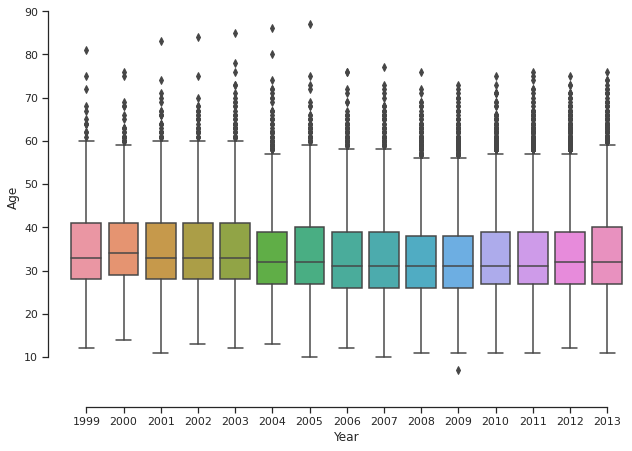

In [23]:
plt.figure(figsize=(10,7))
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="Age", data=df1)
sns.despine(offset=20, trim=True)

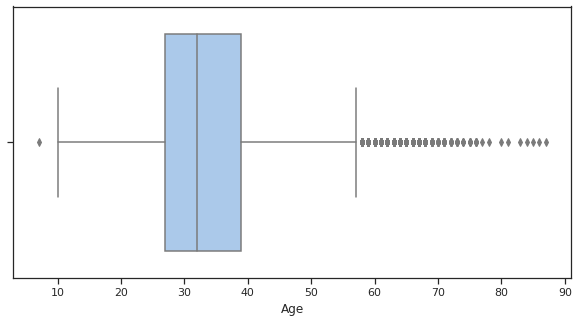

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])

Text(0.5, 1.0, 'Age Distribution')

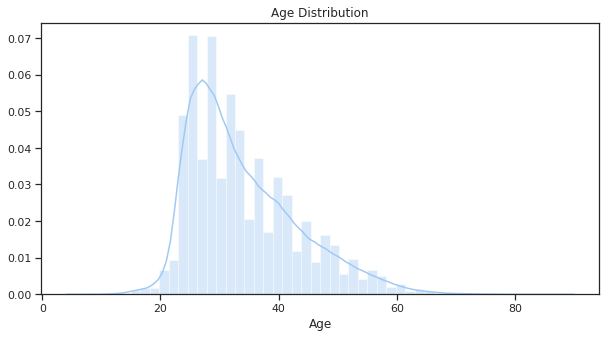

In [25]:
plt.figure(figsize=(10,5))
sns.distplot(df1['Age'])
plt.title("Age Distribution")

Text(0, 0.5, 'Runners')

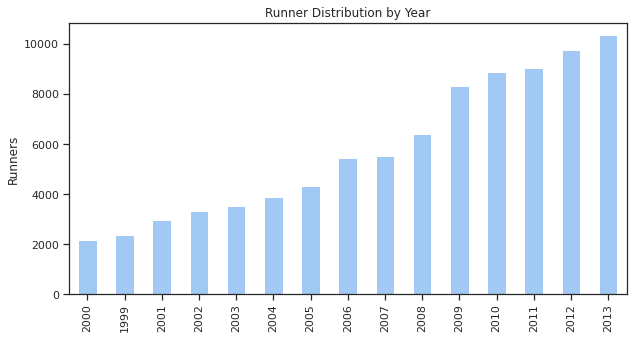

In [26]:
df1.Year.value_counts().nsmallest(15).plot(kind='bar', figsize=(10,5))
plt.title("Runner Distribution by Year")
plt.ylabel("Runners")

,Year,Age
Year,1.000000,-0.033776
Age,-0.033776,1.000000


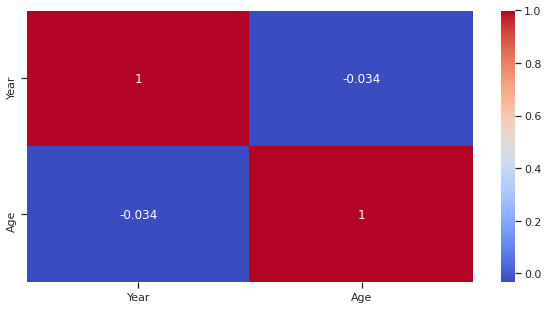

In [27]:
plt.figure(figsize=(10,5))
c= df1.corr()
sns.heatmap(c,cmap='coolwarm',annot=True)
c

In [28]:
df1[["Pace","Time"]].describe()

,Pace,Time
count,86169,86169
unique,651,5199
top,00:09:52,1:36:34
freq,477,62


In [0]:
df1['RunTime'] = [int(a) * 60 + int(b) for a,b,c in df1['Time'].str.split(':')]

In [30]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54


Text(0, 0.5, 'Run Time (minutes)')

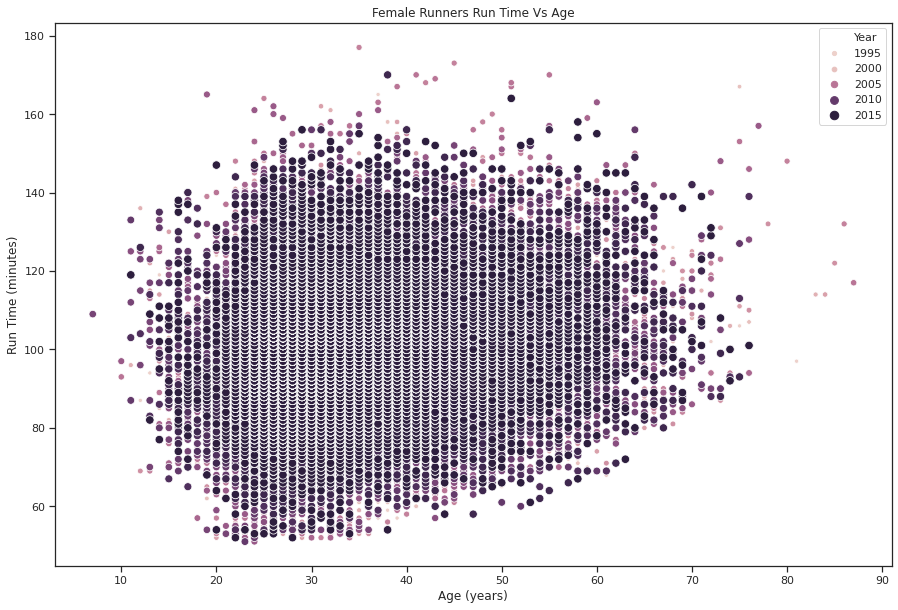

In [31]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.scatterplot(x="Age", y="RunTime", size = "Year", hue = "Year", data=df1)
plt.title('Female Runners Run Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')


Plotting the scatterplot of female runners' run-time per age clearly shows an increase in run-time as age increases. However, it is difficult to see any details on trend due to many points crowded on top of each other. We can see that we have a female runner with less than 10 years of age. 

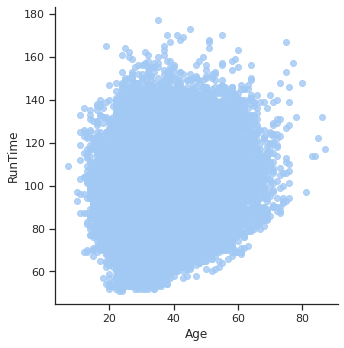

In [32]:
sns.lmplot(x='Age', y='RunTime', data=df1, fit_reg=False);

By applying KDE to smooth the plot.

Text(0, 0.5, 'RunTime (minutes)')

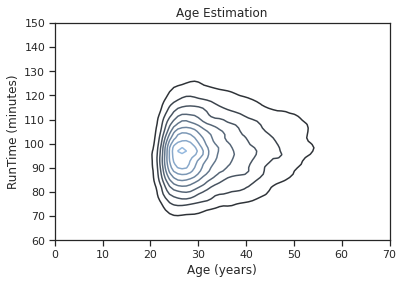

In [33]:
sns.kdeplot(df1['Age'], df1['RunTime'])
plt.xlim(0, 70)
plt.ylim(60, 150);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('RunTime (minutes)')

Clearly we can see that majority of female runners age is between 20 and 60. Therefore, investigation require into our dataset for runners age is between 0 and 10.

In [0]:
bins = [0, 10, 20, 30, 40, 50, 60, 70]
names = ['0-15', '16-25', '26-40', '41-50','51-60', '61-70','71+']

df1['AgeRange'] = pd.cut(df1['Age'], bins, labels=names)


In [35]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime,AgeRange
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53,26-40
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53,26-40
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53,16-25
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54,26-40
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54,26-40


Text(0, 0.5, 'Frequency')

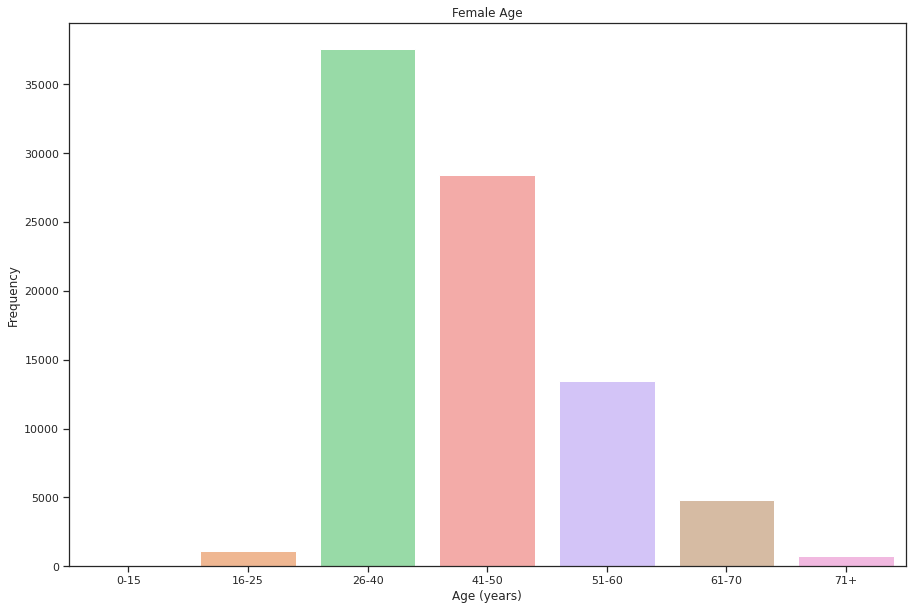

In [36]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.countplot('AgeRange', data=df1)
plt.title('Female Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Frequency')


Text(0, 0.5, 'Run Time (minutes)')

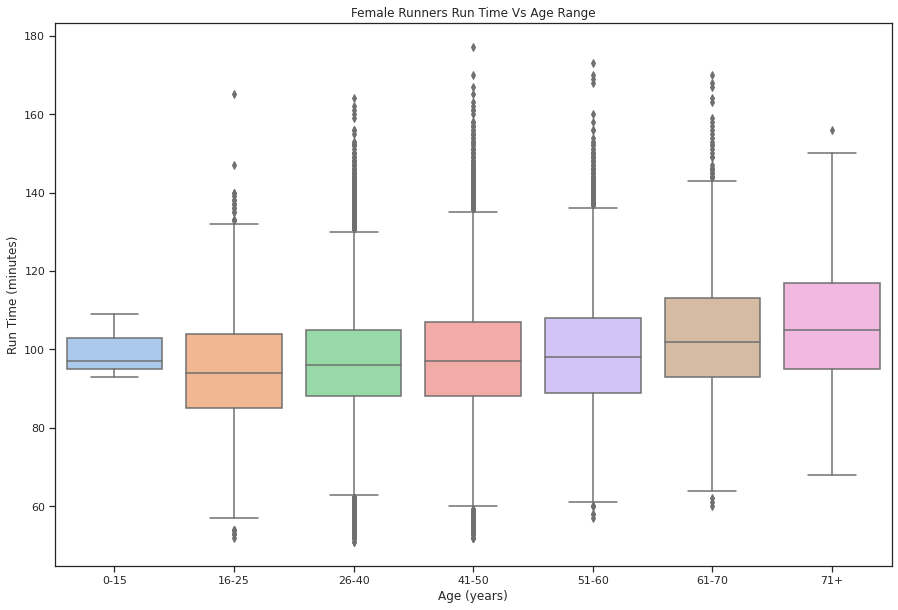

In [37]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="RunTime", data=df1)
plt.title('Female Runners Run Time Vs Age Range')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')

In [0]:
df1['PaceTime'] = [int(a) * 60 + int(b)* 60 + int(c) for a,b,c in df1['Pace'].str.split(':')]

In [39]:
df1.head(5)

,Year,Name,Age,Time,Pace,RunTime,AgeRange,PaceTime
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53,26-40,322
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53,26-40,322
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53,16-25,324
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54,26-40,325
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54,26-40,325


Text(0, 0.5, 'Pace Time (Seconds)')

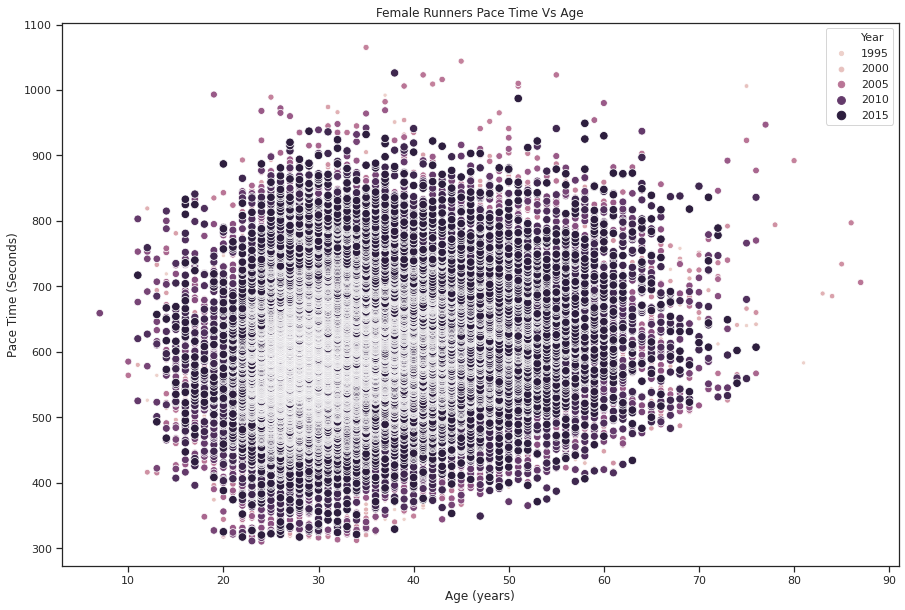

In [40]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.scatterplot(x="Age", y="PaceTime", size = "Year", hue = "Year", data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Pace Time (Seconds)')

Text(0, 0.5, 'PaceTime (seconds)')

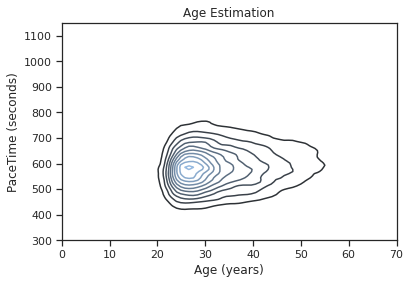

In [41]:
sns.kdeplot(df1['Age'], df1['PaceTime'])
plt.xlim(0, 70)
plt.ylim(300, 1150);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('PaceTime (seconds)')

Text(0, 0.5, 'Years')

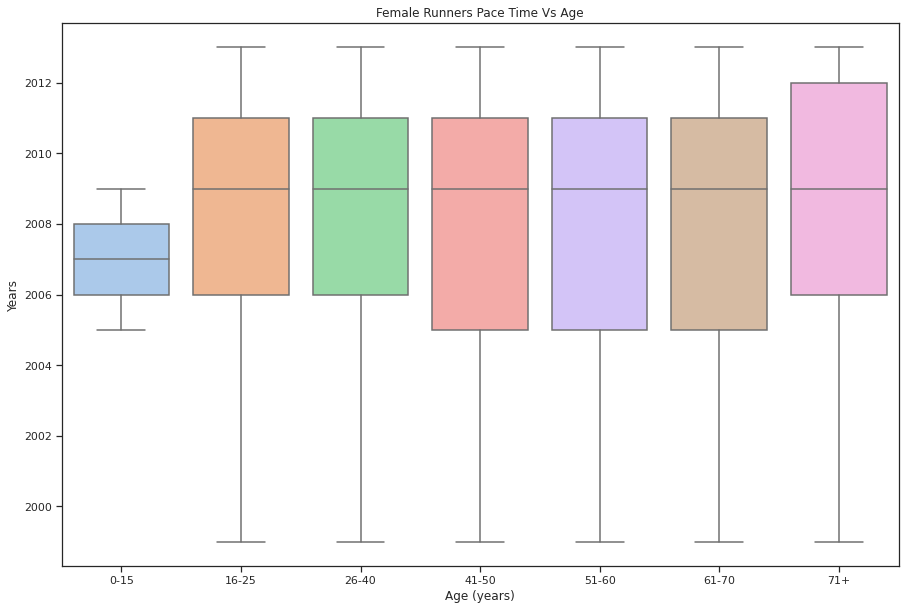

In [42]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="Year", data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Years')

Text(0, 0.5, 'Age (years)')

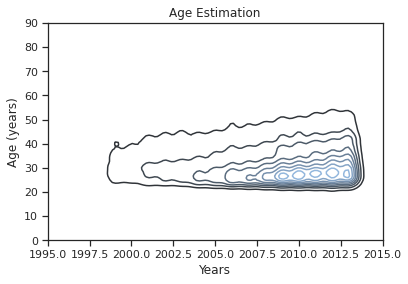

In [43]:
sns.kdeplot(df1['Year'], df1['Age'])
plt.ylim(0, 90)
plt.xlim(1995, 2015);
plt.title('Age Estimation')
# Set x-axis label
plt.xlabel('Years')
# Set y-axis label
plt.ylabel('Age (years)')

Text(0, 0.5, 'Pace Time (seconds)')

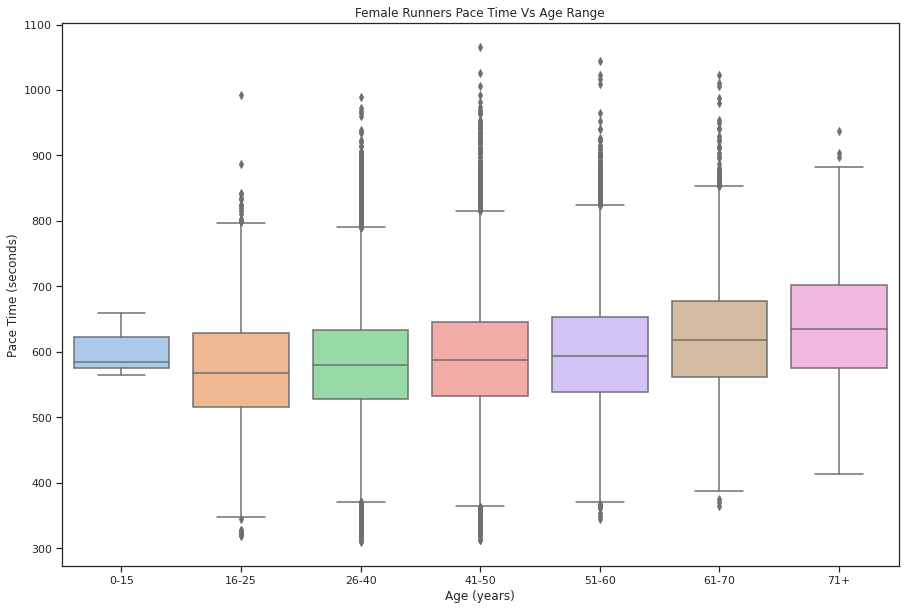

In [44]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="AgeRange", y="PaceTime", data=df1)
plt.title('Female Runners Pace Time Vs Age Range')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Pace Time (seconds)')

Text(0, 0.5, 'Run Time (minutes)')

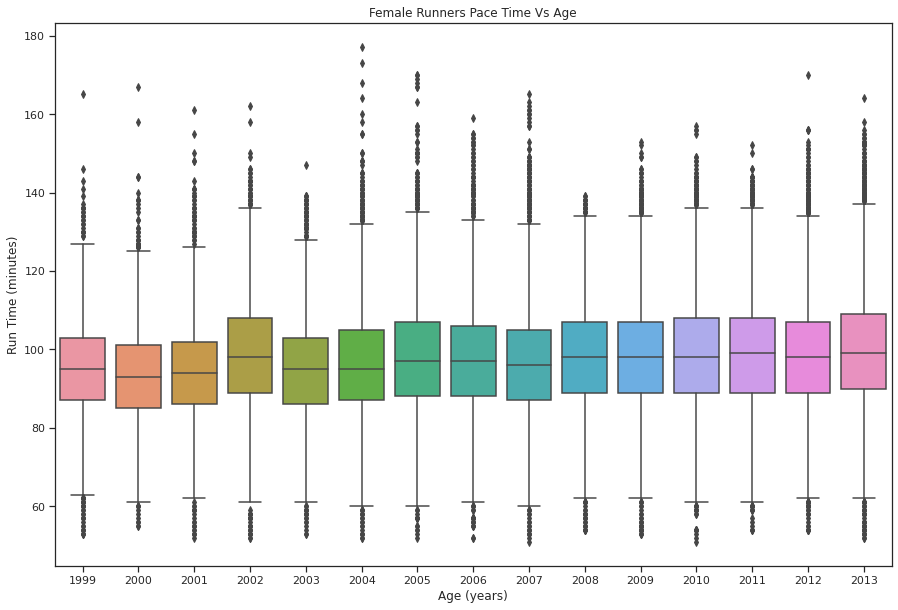

In [45]:
plt.figure(figsize=(15,10))
#sns.set(style="ticks", palette="pastel")
sns.boxplot(x="Year", y="RunTime",  data=df1)
plt.title('Female Runners Pace Time Vs Age')
# Set x-axis label
plt.xlabel('Age (years)')
# Set y-axis label
plt.ylabel('Run Time (minutes)')

Text(0.5, 0, 'Run Time (minutes)')

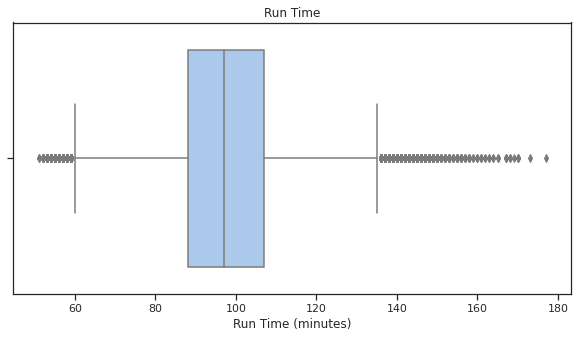

In [46]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["RunTime"])
plt.title('Run Time')
# Set x-axis label
plt.xlabel('Run Time (minutes)')

Text(0.5, 0, 'Age (years)')

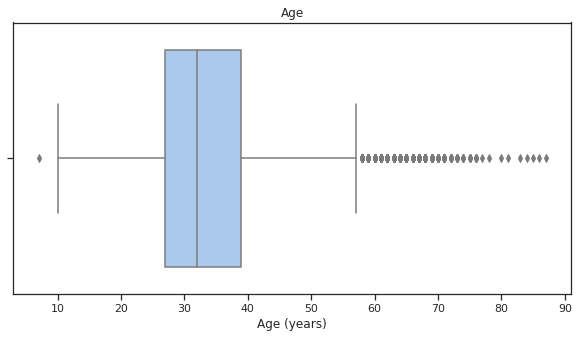

In [47]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df1["Age"])
plt.title('Age')
# Set x-axis label
plt.xlabel('Age (years)')

In [48]:
df1.head()

,Year,Name,Age,Time,Pace,RunTime,AgeRange,PaceTime
0,1999,Jane Omoro (W),26,0:53:37,00:05:22,53,26-40,322
1,1999,Jane Ngotho (W),29,0:53:38,00:05:22,53,26-40,322
2,1999,Eunice Sagero (W),20,0:53:55,00:05:24,53,16-25,324
3,1999,Alla Zhilyayeva (W),29,0:54:08,00:05:25,54,26-40,325
4,1999,Teresa Wanjiku (W),24,0:54:10,00:05:25,54,26-40,325


### Linear Regression

Next we will explore linear regression techniques to see if we can forecast future average ages as well as see if we can predict the ages of the runners based on the time. 

In [49]:
#separating input data into two parts X (features) and Y (target)
features = ['Year', 'RunTime', 'PaceTime']

X = df1[features].copy()

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation

Y= df1[['Age']].copy()
Y.shape

(86169, 1)

Cross Validation

In [0]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [0]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [0]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

Making Custom Estimators

In [0]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100)

Baseline LInear Regression Grid Search

In [54]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters3 = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearchbase = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters3
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearchbase.fit(X, Y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=CappedLinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [55]:
#Print the parameterization of the best estimator
regGridSearchbase.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=True)

In [56]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimatorbase = regGridSearchbase.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimatorbase, X, Y, cv)

The average MAE for all cv folds is: 			 7.3529
The average MAE percentage (MAPE) for all cv folds is: 	 22.332
The average RMSE for all cv folds is: 			 9.1564
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.362397,22.203248,9.202555
1,7.346731,22.245239,9.178634
2,7.417983,22.592230,9.213945
3,7.367599,22.418641,9.145784
4,7.361852,22.244816,9.170254
5,7.372857,22.381290,9.192536
6,7.296773,22.271703,9.061802
7,7.335179,22.303049,9.122885
8,7.302884,22.333188,9.088240
9,7.364664,22.329016,9.187160


Seems like we are off by an average of over 9 years using a baseline linear regression. Next lets try a ridge regression to see if we perform better. 

### Ridge Regression

This model will use Lasso Regressions (L2 Norm) for regression of continuious variables. Documentation below:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html



In [57]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

regrid = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpharid = [0.001, 0.1, 1, 5, 10, 20]
solverrid = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parametersrid = {'alpha': alpharid, 'solver': solverrid}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearchrid = GridSearchCV(estimator=regrid
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parametersrid
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearchrid.fit(X, Y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   28.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, random_state=0,
                             solver='auto', tol=0.0001),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [58]:
#Display the best estimator parameters
regGridSearchrid.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, random_state=0, solver='saga', tol=0.0001)

In [59]:
#Create a regression estimator with best parameters for cross validation
regEstimatorrid = regGridSearchrid.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimatorrid, X, Y, cv)

The average MAE for all cv folds is: 			 7.353
The average MAE percentage (MAPE) for all cv folds is: 	 22.333
The average RMSE for all cv folds is: 			 9.1564
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.361206,22.199728,9.201621
1,7.346964,22.245987,9.178145
2,7.418005,22.593024,9.213746
3,7.367753,22.418738,9.146120
4,7.362280,22.244970,9.170503
5,7.372500,22.380783,9.192101
6,7.297203,22.272974,9.062266
7,7.335715,22.305025,9.123511
8,7.303124,22.333775,9.088812
9,7.365075,22.330452,9.187287


After performing a ridge regression, we didn't perform any better than our baseline linear regression. This is likely due to our age group and race times being highly varied. So the relationship between age and race time is going to be muddied by the variances.

Next let's do a simple linear regression to predict the average age of 2013's data using the data from 1999 - 2012.

In [0]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

Now let's set up our dataframe so that we are grouping the ages by year. 

In [0]:
dfage = df1.groupby('Year')['Age'].mean().reset_index()


In [62]:
dfage

,Year,Age
0,1999,34.886576
1,2000,35.553555
2,2001,34.821272
3,2002,35.137838
4,2003,35.036028
5,2004,33.939254
6,2005,34.166551
7,2006,33.657038
8,2007,33.439964
9,2008,33.210008


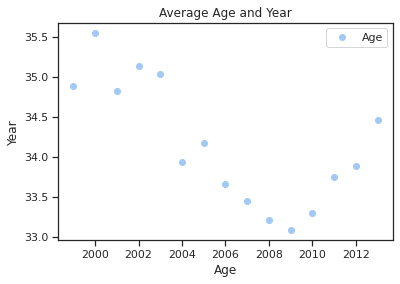

In [63]:
dfage.plot(x='Year', y='Age', style='o')  
plt.title('Average Age and Year')  
plt.xlabel('Age')  
plt.ylabel('Year')  
plt.show()

In [64]:
list(dfage.columns.values)

['Year', 'Age']

In [0]:
x = dfage['Year'].values.reshape(-1,1)
y = dfage['Age'].values.reshape(-1,1)

We will set our training and testing split so that it will only test our final row, the 2013 data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.06, shuffle=False)


In [68]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[352.95251056]
[[-0.15897334]]


In [0]:
y_pred = regressor.predict(X_test)


In [71]:
dfreg = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
dfreg

,Actual,Predicted
0,34.457231,32.939182


In [72]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.518049114227935
Mean Squared Error: 2.304473113208218
Root Mean Squared Error: 1.518049114227935
